# Dask through Jupyter Notebooks

This notebook runs a simple study on SUEP data using Dask, creating an output coffea file that can be analyzed in Dask_analysis.ipynb.

In [17]:
import os
import json
import time
import datetime
import random
import numpy as np
import coffea
coffea.deprecations_as_errors = False #Get rid of warning for now
from coffea import hist, processor
from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


We set up a coffea ABC Processor to analyze the ROOT files.

In [18]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        self._accumulator = processor.dict_accumulator(
            {
                "ht_reco": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_reco", r"$H_T$ [GeV]", 50,0,2500),
                ),
                "ht_reco_triggered": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_reco_triggered", r"$H_T$ [GeV]",  50,0,2500),
                ),
                "nmuons": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("nmuons", r"$N_{muons}$", 30, 0, 30),
                ),
                "muon_pt": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("muon_pt", r"$Muon p_{T}$ [GeV]", 10, 0, 200),
                ),
                "muon_pt_triggered": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("muon_pt_triggered", r"$Muon p_{T}$ [GeV]", 10, 0, 200),
                ),
                "MET": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("MET", r"$p_{T}^{miss}$ [GeV]", 50, 0, 200),
                ),
                "sumw": processor.defaultdict_accumulator(float),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']
        #if "Muon" not in dataset:
        try:
            self.gensumweight = ak.sum(events.genWeight)
            output["sumw"][dataset] += ak.sum(events.genWeight)
        except:
            output["sumw"][dataset] = 1.0
        #output["sumw"][dataset] = 1.0
        
        muons = ak.zip({
            "pt": events.Muon.pt,
            "eta": events.Muon.eta,
            "phi": events.Muon.phi,
            "mass": events.Muon.mass,
            "mediumId": events.Muon.mediumId
        }, with_name="Momentum4D") 
        muon_triggered = muons[events.HLT.IsoMu24 == 1]
        muon_cut = (events.Muon.pt > 10) & \
            (abs(events.Muon.eta) <= 2.4) & \
            (events.Muon.mediumId == 1) 
        muons = muons[muon_cut]
        muon_triggered_cut = (muon_triggered.pt > 10) & \
            (abs(muon_triggered.eta) <= 2.4) & \
            (muon_triggered.mediumId == 1) 
        muon_triggered = muon_triggered[muon_triggered_cut]
        
        Ak4Jets = ak.zip({
            "pt": events.Jet.pt,
            "eta": events.Jet.eta,
            "phi": events.Jet.phi,
            "mass": events.Jet.mass,
        }, with_name="Momentum4D")
        #Ak4Jets = Ak4Jets[events.HLT.Mu45_eta2p1 == 1]#for 2016
        
        if self.era == 2016:
            Jets_triggered = Ak4Jets[(events.HLT.PFHT900 == 1) & (events.HLT.Mu50 == 1)]
        else:
            Jets_triggered = Ak4Jets[(events.HLT.PFHT1050 == 1) & (events.HLT.Mu50 == 1)]
        Ak4Jets = Ak4Jets[events.HLT.Mu50 == 1]
        Ak4JetCut = (Ak4Jets.pt > 30) & (abs(Ak4Jets.eta)<4.7)
        Ak4Jets = Ak4Jets[Ak4JetCut]
        Jets_triggeredCut = (Jets_triggered.pt > 30) & (abs(Jets_triggered.eta)<4.7)
        Jets_triggered = Jets_triggered[Jets_triggeredCut]
                
        # fill out hists

        output['ht_reco'].fill(ht_reco=ak.sum(Ak4Jets.pt,axis=-1), dataset=dataset)
        jet_trig = ak.to_numpy(ak.sum(Jets_triggered.pt,axis=-1),allow_missing=True)
        output['ht_reco_triggered'].fill(ht_reco_triggered=jet_trig, dataset=dataset)
        
        output['nmuons'].fill(nmuons=ak.num(muons, axis=-1), dataset=dataset)
        muons = muons[ak.num(muons, axis=-1)>0]
        output['muon_pt'].fill(muon_pt=ak.max(muons.pt, axis=-1), dataset=dataset)
        muon_trig = ak.to_numpy(ak.max(muon_triggered.pt, axis=-1),allow_missing=True)
        output['muon_pt_triggered'].fill(muon_pt_triggered=muon_trig, dataset=dataset)
        output['MET'].fill(MET=events.MET.pt, dataset=dataset)
                
        return output
        
    def postprocess(self, accumulator):
        return accumulator

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [19]:
# load file names
year = 2016
outDir = '/home/submit/{}/public_html/{}/'.format(os.environ['USER'], 'SUEP/analysis/trigSF/')


if not os.path.isdir(outDir): os.mkdir(outDir)

with open('/home/submit/lavezzo/luca_json/'+str(year)+'_new.json', 'r') as f: samples = json.load(f)

datalist = []
nBad = 0
for k in list(samples.keys()):

    if 'data' in k.lower(): 
        datalist += samples.pop(k)

if len(datalist) >0: samples['Data'] = datalist

print(samples.keys())

dict_keys(['QCDHT1000to1500', 'QCDHT1000to1500preVFP', 'QCDHT100to200', 'QCDHT100to200preVFP', 'QCDHT1500to2000', 'QCDHT1500to2000preVFP', 'QCDHT2000toInf', 'QCDHT2000toInfpreVFP', 'QCDHT200to300', 'QCDHT200to300preVFP', 'QCDHT300to500', 'QCDHT300to500preVFP', 'QCDHT500to700', 'QCDHT500to700preVFP', 'QCDHT50to100', 'QCDHT50to100preVFP', 'QCDHT700to1000', 'QCDHT700to1000preVFP'])


In [19]:
# produce a skimmed dict with 10% of files of original samples
fraction = 0.1

skimmedSamples = {}
for k in list(samples.keys()):

    nFiles = round(len(samples[k])*fraction)
    toAdd = random.sample(samples[k], nFiles)
    skimmedSamples[k] = toAdd

In [20]:
# cross section
xsections = {}
for sample in list(samples.keys()):
    xsection = 1.0
    if 'QCD' in sample:
        with open('../data/xsections_{}.json'.format(year)) as file:
            MC_xsecs = json.load(file)

            if year == 2016:
                if 'preVFP' in sample:
                    sample_name = 'QCD_'+sample[3:-6]+'_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8+RunIISummer20UL16MiniAODAPVv2-106X_mcRun2_asymptotic_preVFP_v11-v1+MINIAODSIM'
                else:
                    sample_name = "QCD_"+sample[3:]+"_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8+RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v1+MINIAODSIM"
            elif year == 2017:
                sample_name = 'QCD_'+sample[3:]+"_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL17MiniAODv2-106X_mc2017_realistic_v9-v1+MINIAODSIM"

            try:
                xsection *= MC_xsecs[sample_name]["xsec"]
                xsection *= MC_xsecs[sample_name]["kr"]
                xsection *= MC_xsecs[sample_name]["br"]
            except:
                print("WARNING: I did not find the xsection for that MC sample. Check the dataset name and the relevant yaml file")
                print(sample_name)

        xsections.update({sample:xsection})
    else:
        xsections.update({sample:xsection})

QCD_HT200to300_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8+RunIISummer20UL16MiniAODAPVv2-106X_mcRun2_asymptotic_preVFP_v11-v1+MINIAODSIM


In [21]:
xsections

{'QCDHT1000to1500': 1118.0,
 'QCDHT1000to1500preVFP': 1118.0,
 'QCDHT100to200': 23630000.0,
 'QCDHT100to200preVFP': 23630000.0,
 'QCDHT1500to2000': 108.9,
 'QCDHT1500to2000preVFP': 108.9,
 'QCDHT2000toInf': 21.93,
 'QCDHT2000toInfpreVFP': 21.93,
 'QCDHT200to300': 1554000.0,
 'QCDHT200to300preVFP': 1.0,
 'QCDHT300to500': 323800.0,
 'QCDHT300to500preVFP': 323800.0,
 'QCDHT500to700': 30280.0,
 'QCDHT500to700preVFP': 30280.0,
 'QCDHT50to100': 186100000.0,
 'QCDHT50to100preVFP': 186100000.0,
 'QCDHT700to1000': 6392.0,
 'QCDHT700to1000preVFP': 6392.0}

## Dask Slurm Cluster
WARNING: this is a bit finnicky. Below there is a more stable "Futures Executor" which runs the jobs to the local machine instead of using a Dask Cluster on Slurm.

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [ ]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

slurm_env = [
    'export XRD_RUNFORKHANDLER=1',
    'export XRD_STREAMTIMEOUT=100',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate SUEP',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u210253',
     'echo "----- Found Proxy in: $X509_USER_PROXY"',
     'voms-proxy-info',
     f'sleep $[ ( $RANDOM % 100 )  + 1 ]s'
]

extra_args=[
     "--output=logs/dask_job_output_%j.out",
     "--error=logs/dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 100
memory       = "5 GB"
chunksize    = 10000000
maxchunks    = None

In [10]:
while not check_port(n_port):
    n_port += 1
    time.sleep(5)

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=10,
        processes=processes,
        memory=memory,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8001,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

In [11]:
cluster.adapt(minimum=1, maximum=10)
client = Client(cluster)
print(client)

<Client: 'tcp://18.12.2.9:6822' processes=0 threads=0, memory=0 B>


In [13]:
processor_instance = Simple_Process(isMC=1, era=year, sample='test')
with performance_report(filename="dask-report.html"):

    runner = processor.Runner(
        executor = processor.dask_executor(client = client, retries= 4),
        schema = processor.NanoAODSchema,
        xrootdtimeout = 60,
        chunksize=10000,
        skipbadfiles=True
    )

    output = runner.automatic_retries(retries=3, skipbadfiles=True, func=runner.run,
        fileset=skimmedSamples,
        treename="Events",
        processor_instance=processor_instance,
    )

    now = datetime.datetime.now()
    coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))

[                                        ] | 0% Completed |  0.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed |  4.4s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed |  8.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 12.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 16.4s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 20.4s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 24.2s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 32.4s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 36.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 40.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 44.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 48.3s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 52.4s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed | 56.2s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed |  1min  0.4s

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

[                                        ] | 0% Completed |  1min  2.2s

KeyboardInterrupt: 

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

In [14]:
client.cancel(cluster)

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/lave

## Futures Executor

In [12]:
processor_instance = Simple_Process(isMC=1, era=year, sample='test')

runner = processor.Runner(
        executor = processor.futures_executor(workers = 20),
        #executor = processor.IterativeExecutor(workers=20),
        schema = processor.NanoAODSchema,
        xrootdtimeout = 120,
        chunksize = 10000000,
        skipbadfiles=True
    )

output = runner.automatic_retries(retries=3, skipbadfiles=True, func=runner.run,
    fileset=skimmedSamples,
    treename="Events",
    processor_instance=processor_instance,
)

now = datetime.datetime.now()
coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))

print("Exceptions:", output['exception'])

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52/52 [ 0:06:45 < 0:00:00 | 0.1  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52/52 [ 0:06:45 < 0:00:00 | ?   merges/s ]

Exceptions: 0


## Analysis

In [22]:
# just in case this isn't working as expected
#coffea.util.save(output, "unscaled_output.coffea")

outputs = coffea.util.load("unscaled-21:18:19.coffea")
output = outputs['out']

# calculate normalization
scales = {} 
for dataset in output["sumw"]:
    lumi = 1.0 # don't need to normalize to lumi for this
    if "muon"  in dataset.lower() or 'data' in dataset.lower():
        scale = 1.0
    else:
        xsec = xsections[dataset]
        scale = lumi * xsec / output["sumw"][dataset]
    scales.update({dataset: scale})


# apply normalization to all histograms
for key in list(output.keys()):
    if key.lower() == 'sumw': continue
    print(key)
    output[key].scale(scales, axis='dataset')

coffea.util.save(output, "10percent_MC_2016.coffea")

ht_reco
ht_reco_triggered
nmuons
muon_pt
muon_pt_triggered
MET


### We can make some plots here too! But most of the analysis is in Dask_analysis.ipynb

In [30]:
output = coffea.util.load("10percent_MC_2016.coffea")
output_mu = coffea.util.load("10percent_Muon_2016.coffea")

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, None)


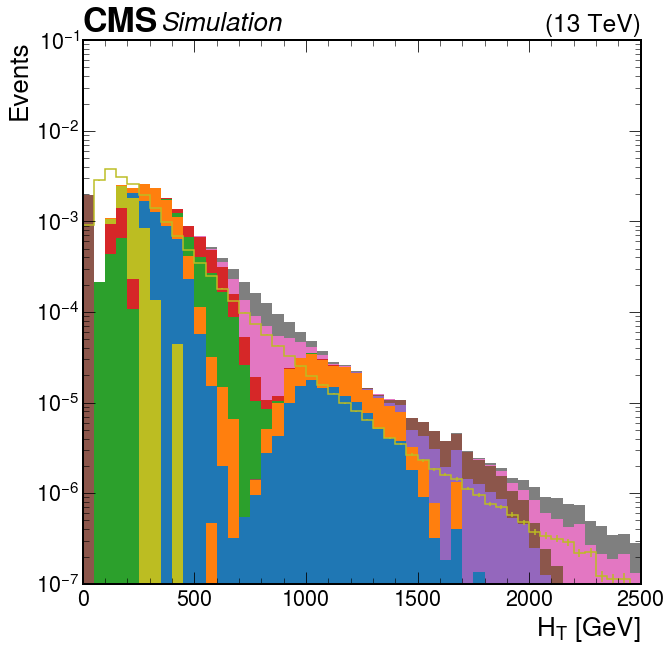

In [31]:
from coffea.hist import plot
import matplotlib.pyplot as plt
import mplhep as hep

fig = plt.figure()
ax = fig.subplots()

#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)

_ = ax.set_yscale('log')
coffea.hist.plot.plot1d(output['ht_reco']['QCDHT*'], ax=ax, clear=False, stack=True, density=True)
coffea.hist.plot.plot1d(output_mu['ht_reco']['Data'], ax=ax, clear=False, stack=False, density=True)

_ = ax.set_xlim(0, 2500)
_ = ax.set_ylim(1e-7, 1e-1)
ax.get_legend().remove()

plt.savefig(outDir + 'ht_reco_{}.pdf'.format(year))

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, None)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, None)


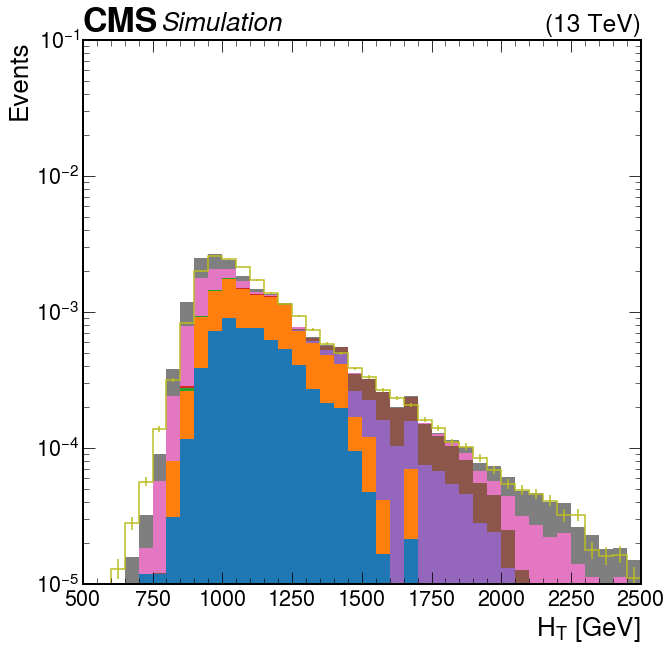

In [32]:
fig = plt.figure()
ax = fig.subplots()

#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)

_ = ax.set_yscale('log')
coffea.hist.plot.plot1d(output['ht_reco_triggered']['QCDHT*'], ax=ax, clear=False, stack=True, density=True)
coffea.hist.plot.plot1d(output_mu['ht_reco_triggered']["Data"], ax=ax, clear=False, stack=False, density=True)
_ = ax.set_xlim(500, 2500)
_ = ax.set_ylim(1e-5, 1e-1)
ax.get_legend().remove()

plt.savefig(outDir + 'ht_reco_triggered_{}.pdf'.format(year))

In [33]:
val_trig = 0
val = 0
var_trig = 0
var = 0
i = 0
for sample in output['ht_reco_triggered'].project('dataset').values():
    if 'QCDHT' not in sample[0]: continue
    bh_trig = output['ht_reco_triggered'][sample[0]].to_boost()
    bh = output['ht_reco'][sample[0]].to_boost() 
    if i == 0:
        bins_use = bh_trig.axes.edges[1][0]
        val_trig = bh_trig.values()[0]
        val= bh.values()[0]
        var_trig = bh_trig.variances()[0]
        var= bh.variances()[0]
    else:
        val_trig += bh_trig.values()[0]
        val += bh.values()[0]
        var_trig += bh_trig.variances()[0]
        var += bh.variances()[0]
    i += 1

#val_trig = np.array([ x+y for x,y in zip(val_trig[0::2], val_trig[1::2]) ])
#val = np.array([ x+y for x,y in zip(val[0::2], val[1::2]) ])
#var_trig = np.array([ x+y for x,y in zip(var_trig[0::2], var_trig[1::2]) ])
#var = np.array([ x+y for x,y in zip(var[0::2], var[1::2]) ])
x = val_trig/val
x2 = np.nan_to_num(x)*100

In [34]:
val_trig_data = 0
val_data = 0
var_trig_data = 0
var_data = 0
i = 0
for sample in output_mu['ht_reco_triggered'].project('dataset').values():
    if 'data' not in sample[0].lower(): continue
    bh_trig_data = output_mu['ht_reco_triggered'][sample[0]].to_boost()
    bh_data = output_mu['ht_reco'][sample[0]].to_boost()
    if i == 0:
        val_trig_data = bh_trig_data.values()[0]
        val_data= bh_data.values()[0]
        var_trig_data = bh_trig_data.variances()[0]
        var_data= bh_data.variances()[0]
    else:
        val_trig_data += bh_trig_data.values()[0]
        val_data += bh_data.values()[0]
        var_trig_data+= bh_trig_data.variances()[0]
        var_data += bh_data.variances()[0]
    i += 1
    
    
#val_trig_data = np.array([ x+y for x,y in zip(val_trig_data[0::2], val_trig_data[1::2]) ])
#val_data = np.array([ x+y for x,y in zip(val_data[0::2], val_data[1::2]) ])
#var_trig_data = np.array([ x+y for x,y in zip(var_trig_data[0::2], var_trig_data[1::2]) ])
#var_data = np.array([ x+y for x,y in zip(var_data[0::2], var_data[1::2]) ])
x_data = val_trig_data/val_data
x_data2 = np.nan_to_num(x_data)*100

In [35]:
#bins_use=bins_use[0::2]
import hist
from hist import intervals
MC_err = hist.intervals.ratio_uncertainty(num=val_trig,denom=val,uncertainty_type='efficiency')
data_err = hist.intervals.ratio_uncertainty(num=val_trig_data,denom=val_data,uncertainty_type='efficiency')

In [36]:
binc = np.array([ 0.5*(bins_use[i]+bins_use[i+1])for i in range(bins_use.shape[0]-1)])
xerr = np.diff(bins_use)*0.5

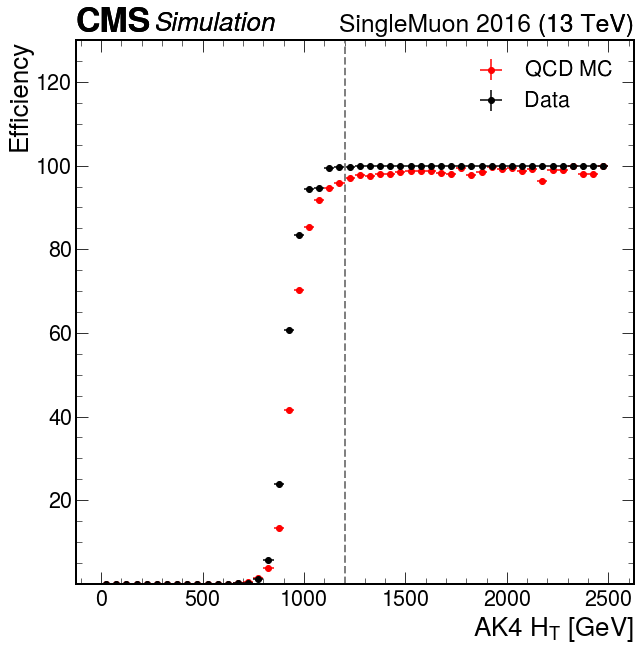

In [37]:
fig = plt.figure()
ax = fig.subplots()

hep.cms.label(data=False, year='SingleMuon '+str(year))
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
binc = np.array([ 0.5*(bins_use[i]+bins_use[i+1])for i in range(bins_use.shape[0]-1)])
plt.errorbar(binc,x_data2, xerr=xerr,yerr=[data_err[0],data_err[1]],color="red", fmt='o')
plt.errorbar(binc,x2, xerr=xerr,yerr=[MC_err[0],MC_err[1]],color="black", fmt='o')
#plt.axvline(x=1200, color='gray',ls='--', lw=2)
_ = ax.set_ylim(0.001, 130)
_ = ax.set_ylabel("Efficiency")
_ = ax.set_xlabel(r"AK4 $H_{T}$ [GeV]")
plt.rcParams['text.usetex'] = True
labels = [r"QCD MC",r"Data"]
leg = ax.legend(labels=labels)
plt.axvline(x=1200, color='gray',ls='--', lw=2)

plt.savefig(outDir + 'eff_{}.pdf'.format(year))

In [38]:
z=np.nan_to_num(x_data2/x2)
z=np.clip(z,0,15)
z_up = np.nan_to_num((x_data2+data_err[0])/(x2-MC_err[1])) - z
z_up = np.clip(z_up,0,15)
z_down = z - np.nan_to_num((x_data2-data_err[1])/(x2+MC_err[0]))
z_down = np.clip(z_down,0,15)

/tmp/ipykernel_3824624/1942878560.py:1: RuntimeWarning: divide by zero encountered in true_divide
  z=np.nan_to_num(x_data2/x2)
/tmp/ipykernel_3824624/1942878560.py:1: RuntimeWarning: invalid value encountered in true_divide
  z=np.nan_to_num(x_data2/x2)
/tmp/ipykernel_3824624/1942878560.py:5: RuntimeWarning: divide by zero encountered in true_divide
  z_down = z - np.nan_to_num((x_data2-data_err[1])/(x2+MC_err[0]))


In [39]:
#z=np.clip(z,0,1.5)
#z_up=np.clip(z_up,0,1.5)
#_down=np.clip(z_down,0,1.5)

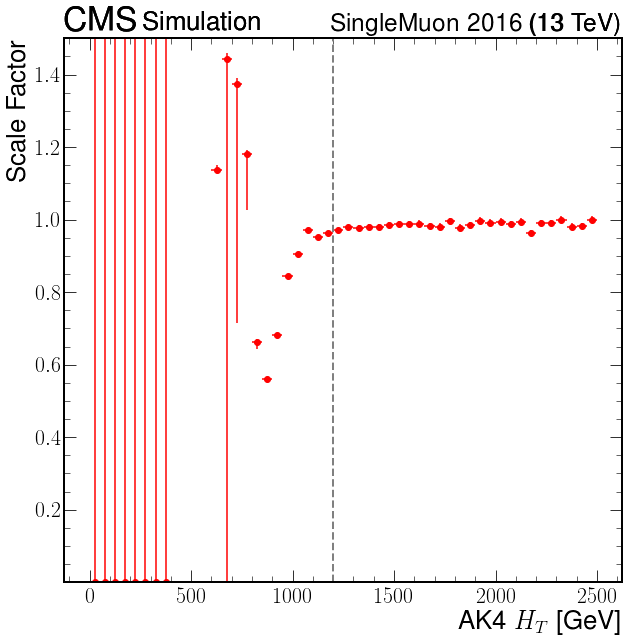

In [40]:
fig = plt.figure()
ax = fig.subplots()

hep.cms.label(data=False, year='SingleMuon '+str(year))
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
plt.errorbar(binc,z, xerr=xerr,yerr=[z_up,z_down],color="red", fmt='o')
_ = ax.set_ylim(0.001, 1.5)
_ = ax.set_ylabel("Scale Factor")
_ = ax.set_xlabel(r"AK4 $H_{T}$ [GeV]")
plt.axvline(x=1200, color='gray',ls='--', lw=2)

plt.savefig(outDir + 'trigSF_{}.pdf'.format(year))

In [41]:
import uproot
outfile = uproot.recreate(outDir+"trigSF_{}.root".format(year))

In [42]:
z_var = np.maximum(z_up,z_down)

In [43]:
z_var

array([1.50000000e+01, 1.50000000e+01, 1.50000000e+01, 1.50000000e+01,
       1.50000000e+01, 1.50000000e+01, 1.50000000e+01, 1.50000000e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.02601505e-02,
       1.33013730e-02, 2.83684425e+00, 6.60732683e-01, 1.53535149e-01,
       1.99733824e-02, 5.53714764e-03, 2.88024612e-03, 3.11405635e-03,
       3.38847380e-03, 4.35936698e-03, 4.93450225e-03, 5.22216349e-03,
       5.83220354e-03, 7.31303772e-03, 7.82895858e-03, 8.25160791e-03,
       8.31565179e-03, 9.30415832e-03, 9.45990774e-03, 9.65637402e-03,
       9.77381211e-03, 9.65847853e-03, 9.76070745e-03, 9.88272094e-03,
       9.75426608e-03, 9.81511771e-03, 9.89460058e-03, 9.86923682e-03,
       9.89110785e-03, 9.85657079e-03, 9.88928173e-03, 9.69020374e-03,
       9.88423534e-03, 9.88439787e-03, 9.90099010e-03, 9.86815173e-03,
       9.86877031e-03, 9.90099010e-03])

In [44]:
import boost_histogram as bh
newhist = bh.Histogram(bh.axis.Variable(bins_use),storage=bh.storage.Weight())
newhist[:] = np.stack([z, z_var], axis=-1)

In [45]:
#outfile['efficiency_Data'] = x_data2
#outfile['efficiency_MC'] = x_2
outfile['TriggerSF'] = newhist
outfile.close()

In [13]:
import uproot
import mplhep as hep
import matplotlib.pyplot as plt

infile = uproot.open("/home/submit/lavezzo/SUEP/paper_version/SUEPCoffea_dask/data/trigSF/trigSF_2018.root")

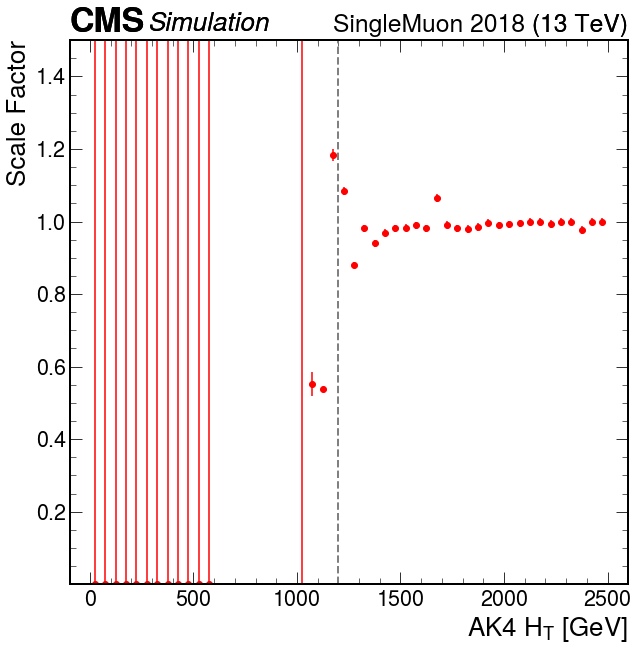

In [25]:
h = infile['TriggerSF'].to_hist()
binc = h.axes[0].centers
z = h.values()
z_up, z_down = h.variances(), h.variances()

fig = plt.figure()
ax = fig.subplots()

hep.cms.label(data=False, year='SingleMuon 2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
plt.errorbar(binc,z,yerr=[z_up,z_down],color="red", fmt='o')
_ = ax.set_ylim(0.001, 1.5)
_ = ax.set_ylabel("Scale Factor")
_ = ax.set_xlabel(r"AK4 $H_{T}$ [GeV]")
plt.axvline(x=1200, color='gray',ls='--', lw=2)

plt.savefig(outDir + 'trigSF_{}.pdf'.format(2018))